# Using Jupyter Notebooks with SWI-Prolog

This notebook gives an introduction to the usage of SWI-Prolog in a Jupyter notebook with the
[Prolog Jupyter Kernel](https://github.com/anbre/prolog-jupyter-kernel).<br>

The main requirement for the Prolog Jupyter kernel was for the usage to be as similar to a Prolog REPL as possible.<br>
Therefore, any code to be executed needs to be valid Prolog code and the output mostly resembles the console output.<br>
Additionally, some Jupyter specific messages are printed such as information about the Prolog server (which is responsible for code execution) being halted or restarted.<br>

A code cell can contain more than one Prolog term.<br>
Each of these terms can be a clause definition, directive, or query.<br>
Any variable bindings or other output produced by the terms is displayed in the cell's output.<br>

A main difference compared to the usage in a console is that no user interaction is possible.<br>
Therefore, [computing further solutions](#multiple_solutions) for a goal needs to be handled differently.<br>
Additionally, [debugging](#debugging) cannot be executed as usual.<br>
A major advantage over using a Prolog REPL is that [predicate (re-)definition](#predicate_definition) is more straightforward.<br>
Another convenience the kernel provides is that if the last term of a cell is missing the terminating full-stop, the code can be executed anyway. <br>

## Kernel Configuration <a id='kernel_configuration'></a>

The Prolog implementation with which the Prolog Jupyter kernel executes code can be configured (see the [configuration options of the Prolog kernel](https://github.com/anbre/prolog-jupyter-kernel#configuration)).
Without any configuration, code cells are exectued with SWI-Prolog by default.<br>

In addition to configuring the Prolog implementation, it can be changed with `jupyter:set_prolog_impl(+PrologImplementationID)` (see [Change the Prolog Implementation](#change_prolog_implementation)).<br>
In order for this to work, implementation specific data needs to be configured for more than one Prolog implementation.

For an example of the usage of the kernel with SICStus Prolog, see [Using_Jupyter_Notebooks_with_SICStus_Prolog.ipynb](sicstus/Using_Jupyter_Notebooks_with_SICStus_Prolog.ipynb).

## Overview

This notebook is structured by the features which the Prolog kernel provides.<br>
For each of them, examples are provided which show some possible use cases.<br>
Furthermore, possible peculiarities are explained.

Some of the features correspond to particularities of Prolog that stem from using SLD-resolution as its execution mechanism.<br>
Others are non-standard features that are available in almost every Prolog implementation.<br>
Additionally, there is kernel specific functionality which is provided mostly for user convenience.

Prolog Particularities:
- [Predicate (Re-)Definition](#predicate_definition)
- [Query Execution](#query_execution)
- [Handling Multiple Solutions](#multiple_solutions)

De-Facto Standard Prolog Features:
- [Loading Source Files and Libraries](#load)
- [Running Automated Tests](#automated_tests)
- [Benchmarking Capabilities](#benchmarking)
- [Debugging](#debugging)

Jupyter Convenience Features
- [Introspection](#introspection)
    - [Code completion](#code_completion)
    - [Inspection](#inspection)
    - [Accessing `juypter` documentation](#jupyter_docs)
- [Resetting the Prolog State](#reset_state)
- [Accessing Previous Results](#previous_results)
- [Structured Output](#structured_output)
- [Printing SLD Trees](#sld_trees)
- [Creating Transition Graphs](#transition_graphs)
- [Changing the Prolog Implementation](#changing_prolog_implementation)

## Prolog Particularities

### Predicate (Re-)Definition <a id='predicate_definition'></a>

If a cell contains more than one term, in general, all terms are added as dynamic facts to the data base.<br>
The only exceptions are queries or directives starting with `?-` or `:-` and PL-Unit test definitions.<br>

All defined clauses can be module name expanded such as `Module:Head :- Body.`. <br>
If no module name is defined, the module `user` is chosen by default.<br>
In order to let the user know the exact predicate which was defined, a message containing the module name and predicate name and arity is output.

In [1]:
app([], Res, Res).
app([H|T], List, [H|Res]) :-
  app(T, List, Res).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Asserting clauses for user:app/3
</pre>

It needs to be noted that if a potential query of the form `Head.` appears as a single term in a cell, it is executed as a query.<br>
If users want to assert a single fact, they can achieve it by writing a term of the form `Head :- Body.`.<br>

In [2]:
app(L1, L2, L3, Res) :-
  app(L2, L3, R1),
  app(L1, R1, Res).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Asserting clauses for user:app/4
</pre>

The use of Prolog in a Jupyter application is meant for interactive programming.<br>
This involves writing, testing and re-writing clauses rather than only adding new clauses to the fact database.<br>
Therefore, by default, when clauses are defined for a dynamic predicate for which there are existing ones, these are retracted first.<br>
Thus, all clauses of a predicate need to be defined in one cell.<br>

In case clauses were retracted, the user is informed.<br>
This is done by a message preceding all other output.<br>
The message can be expanded in order to see the exact clauses which were retracted.<br>

In [3]:
user:app([], Res, Res) :- !.
user:app([Head|Tail], List, [Head|Res]) :-
  app(Tail, List, Res).

Previously defined clauses of user:app/3 were retracted:
:- dynamic app/3.

app([], A, A).
app([A|B], C, [A|D]) :-
    app(B, C, D).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Asserting clauses for user:app/3
</pre>

In order to be able to define clauses for a predicate in separate cells, the corresponding predicate can be declared discontiguous.<br>
In that case, it also needs to be declared dynamic.

In [4]:
:- discontiguous fact/1.
:- dynamic fact/1.

In [5]:
fact(a).
fact(b).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Asserting clauses for user:fact/1
</pre>

In [6]:
fact(c).
fact(d).
?- listing(fact/1).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Asserting clauses for user:fact/1
</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">:- dynamic fact/1.

fact(a).
fact(b).
fact(c).
fact(d).
</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

When removing a predicate with `abolish`, its properties are removed as well.<br>
Therefore, afterwards previous clauses are retracted again when new ones are defined.

In [7]:
?- abolish(fact/1).
fact(a).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Asserting clauses for user:fact/1
</pre>

In [8]:
fact(b).
fact(c).
?- listing(fact/1).

Previously defined clauses of user:fact/1 were retracted:
:- dynamic fact/1.

fact(a).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Asserting clauses for user:fact/1
</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">:- dynamic fact/1.

fact(b).
fact(c).
</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

Additionally, clauses can be defined in the form of DCG rules.

In [9]:
number(Number) --> "+", number(Number).
number(NegativeNumber) --> "-", number(Number), {NegativeNumber is -Number}.
number(Number) --> [Digit], {"0"=<Digit, Digit=<"9", Number is Digit - "0"}.

?- atom_codes('-1', _Codes), phrase(number(N), _Codes).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Asserting clauses for user:number/3
</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">N = -1</pre>

### Query Execution <a id='query_execution'></a>

As mentioned above, if a cell contains a single potential query, it is interpreted as such as opposed to the definition of a clause.<br>
Additionally, terms starting with `?-` and directives starting with `:-` are evaluated as queries even if they appear in a cell with multiple other terms.

If a query succeeds and binds any variables, the bindings are shown in the output of the cell.<br>
Analogously, if there are no bindings, `true` is printed and if a query fails, `false` is output.

In [10]:
X = [1,2,3], append(X, [4,5,6], Z).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">X = [1,2,3],
Z = [1,2,3,4,5,6]</pre>

In [ ]:
?- member(2, [1, 2, 3]).
?- member(4, [1, 2, 3])

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;color:red; font-weight:bold;">false</pre>

If a query causes an exception, the exception message is printed in red.

In [ ]:
7 is 1 + y.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;color:red; font-weight:bold;">ERROR: is/2: Arithmetic: `y/0' is not a function
</pre>

If the execution produces any output, it is displayed preceding the other information.

In [13]:
format('Using ~w Prolog!~n', ['SWI']).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">Using SWI Prolog!</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

Just like in a Prolog REPL, no variable bindings are output for directives.

In [14]:
:- member(M, [1, 2, 3]), print(M).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">1</pre>

### Handling Multiple Solutions <a id='multiple_solutions'></a>

When a query succeeds with a choice point, one can request further solutions via backtracking.<br>
The Jupyter kernel mimics this by providing the predicate `jupyter:retry/0`.<br>
Whenever a query is executed, it is seen as the active query as long as there might be further solutions for it.<br>
If there is an active query, a `retry` may trigger backtracking to compute the next solution.<br>
In order to let the user know which query is retried, a corresponding message is output.<br>

Additionally, the predicate `jupyter:cut/0` is exposed.<br>
It cuts off choicepoints of the active execution and marks an older query which might have open choice points as active.<br>
The user is informed about the new active query.

Since backtracking is a Prolog feature which is used frequently, these two predicates can be called without stating the module and cannot be redefined in the `user` module.<br>

In order to see all queries which can be retried, the predicate `jupyter:print_stack/0` can be called, which outputs the current stack.<br>
The currently active query is printed at the top and indicated by a preceding arrow.

It needs to be noted that all of these predicates do not work unless they are the only goal in a query.<br>

In [15]:
?- member(M, [1, 2]).
?- member(M, [a, b, c]).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">M = 1</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">M = a</pre>

In [16]:
jupyter:retry.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Retrying goal: member(M,[a,b,c])
</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">M = b</pre>

In [17]:
jupyter:print_stack

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">->  member(M,[a,b,c])
    member(M,[1,2])
    format(Using ~w Prolog!~n,[SWI])
    member(2,[1,2,3])
    X=[1,2,3],append(X,[4,5,6],Z)
    atom_codes(-1,_Codes),phrase(number(N),_Codes)
    listing(fact/1)
    abolish(fact/1)
    listing(fact/1)</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

In [18]:
cut.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% The new active goal is: member(M,[1,2])</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

In [19]:
retry.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Retrying goal: member(M,[1,2])
</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">M = 2</pre>

The `retry` and `cut` mechanism can be useful when:
- Computing the solution of a query
- Further inspecting the solution with a different query
- Computing the next solution and further inspecting it

This is especially useful when the computation of the first solution took so long that it should not be executed again.

For an explanation of `$Var` terms, see [Accessing Previous Results](#previous_results).


In [20]:
is_odd(X) :-
  1 is X mod 2.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Asserting clauses for user:is_odd/1
</pre>

In [21]:
member(M, [1, 2, 3, 4, 5]).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">M = 1</pre>

In [22]:
is_odd($M).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">M = 1</pre>

In [ ]:
?- cut.
?- retry.
?- is_odd($M).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% The new active goal is: member(M,[1,2,3,4,5])</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Retrying goal: member(M,[1,2,3,4,5])
</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">M = 2</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;color:red; font-weight:bold;">false</pre>

Note that this time no `cut` is needed because the previous query failed.

In [24]:
?- retry.
?- is_odd($M).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Retrying goal: member(M,[1,2,3,4,5])
</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">M = 3</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">M = 3</pre>

## De-Facto Standard Prolog Features

### Loading Source Files and Libraries <a id='load'></a>

Loading source files and libraries works in the same way as on a Prolog REPL.<br>
Predicates are always re-defined when encountered (as user interaction is not possible during the load).

In [25]:
use_module(library(lists)).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

In [26]:
append([[1], [2], [3]], L). 

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">L = [1,2,3]</pre>

Note that loading a library and using operators from that library does not work in a single query.<br>
The term needs to be read by the built-in predicate `read_term/3`, which throws a syntax error when encountering undefined operators.

In [ ]:
use_module(library(clpfd)), X #< 10, X #> 5.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;color:red; font-weight:bold;">ERROR: Syntax error: Operator expected
ERROR: use_module(library(clpfd)), X
ERROR: ** here **
ERROR:  #< 10, X #> 5. 
</pre>

In [28]:
use_module(library(clpfd)).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

In [29]:
X #< 10, X #> 5.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">X in 6..9</pre>

### Running Automated Tests <a id='automated_tests'></a>

`library(plunit)` can be used to define and run automated tests.<br>
Tests can either be defined in a file which is loaded or in a cell.<br>
In the latter case, any definition of a `test/1` or `test/2` clause needs to be preceded by a `begin_tests` directive.<br>
Additionally, if there is an optional `end_tests` directive, it needs to follow the test clauses.<br>
Otherwise, they are not recognized as such.<br>

In [30]:
:- begin_tests(list). 

test(list) :-
  lists:is_list([]).

:- end_tests(list).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">
% Defined test unit list</pre>

In [31]:
run_tests.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% PL-Unit: list . done
% test passed</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

As can be seen, after defining new test units, the previous ones still exist.

In [32]:
:- begin_tests(number). 

test(number_failing, [fail]) :-
  number([]).
  
:- run_tests.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">
% Defined test unit number</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% PL-Unit: list . done
% PL-Unit: number . done
% All 2 tests passed</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

As mentioned above, test definitions can also be loaded from a file.

In [33]:
[test].

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

In [34]:
run_tests.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% PL-Unit: list . done
% PL-Unit: number . done
% PL-Unit: test ... done
% All 5 tests passed</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

### Benchmarking Capabilities <a id='benchmarking'></a>

Whenever a query is executed, its runtime is stored in a database.<br>
It can be accessed by calling `jupyter:print_query_time`, which prints the latest previous query and its runtime in milliseconds.<br>

In [35]:
member(M, [1,2,3]).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">M = 1</pre>

In [36]:
jupyter:print_query_time.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">Query:   member(M,[1,2,3])
Runtime: 0 ms</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

### Debugging <a id='debugging'></a>

In a Jupyter notebook, debugging cannot be performed interactively as user input is not supported during the execution of a cell.<br>
Thus, switching on trace mode with `trace/0` would cause the server to stop at an invocation (and a restart is required).<br>
However, the call stack can be accessed by defining breakpoints which cause debugging messages to be printed.<br>
As this mechanism might be difficult, the predicate `jupyter:trace(Goal)` was implemented.<br>
It switches on trace mode, calls the goal `Goal` and switches debug mode off.<br>
By default, all ports are unleashed and included in the output, which means that no user interaction is requested when a breakpoint is activated.<br>
In order to be recognized as a special goal, the call of `jupyter:trace/1` needs to be the only one in a term.<br>

In [37]:
app([], Res, Res) :- !.
app([Head|Tail], List, [Head|Res]) :-
  app(Tail, List, Res).
  
app(L1, L2, L3, Res) :-
  app(L2, L3, R1),
  app(L1, R1, Res).

Previously defined clauses of user:app/3 were retracted:
:- dynamic app/3.

app([], A, A) :-
    !.
app([A|B], C, [A|D]) :-
    app(B, C, D).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Asserting clauses for user:app/3
</pre>

Previously defined clauses of user:app/4 were retracted:
:- dynamic app/4.

app(A, B, C, D) :-
    app(B, C, E),
    app(A, E, D).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Asserting clauses for user:app/4
</pre>

In [38]:
jupyter:trace(app([1], [2], R)).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">   Call: (181) app([1], [2], _73802)
   Call: (182) app([], [2], _74914)
   Exit: (182) app([], [2], [2])
   Exit: (181) app([1], [2], [1, 2])</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">R = [1,2]</pre>

## Jupyter Convenience Features

### Introspection <a id='introspection'></a>

#### Code Completion (Tab) <a id='code_completion'></a>
In JupyterLab as well as Jupyter Notebook, code completion for the token at the current cursor position can be requested by pressing the Tab key.<br>
If there is a single possible match, the code preceding the cursor is replaced directly.<br>
Otherwise, a list of options is shown from which the user can choose one.<br>
Completion can be used for predicates which are built-in or exported by a loaded module.<br>
It is also possible to display all predicates of a module, which is especially useful for retrieving all the special predicates defined by the module `jupyter`.

When the kernel is started, the needed predicate data can only be retrieved for modules which are currently loaded.<br>
After loading another module, the data can be updated with `jupyter:update_completion_data/0` so that code completion works for predicates from that module as well.

In [39]:
jupyter:update_completion_data.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

#### Inspection (Shift+Tab) <a id='inspection'></a>
By pressing Shift+Tab, inspection for the token preceding the current cursor position can be requested.<br>
For most predicates, the documentation is requested with `help/1`.<br>
Additionally, if the token is contained in a name of a predicate from module `jupyter`, the corresponding documentation is displayed.

#### Accessing `jupyter` documentation <a id='jupyter_docs'></a>

Most of the features below are provided by the module `jupyter` which is used by the Prolog server.<br>
In addition to the inspection, the documentation of all predicates defined in this module can be accessed with `jupyter:help/0`.<br>

In [40]:
jupyter:help

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">jupyter:cut or cut

    Cuts off the choicepoints of the latest active query.

    In general, the previous query is the active one.
    However, the previous active query can be activated again.
    This can be done by cutting off choicepoints with jupyter:cut/0.
    This is also the case if a retry/0 encounters no further solutions.

    A further retry/0 call causes backtracking of the previous active goal.

    Needs to be the only goal of a query.

--------------------------------------------------------------------------------

jupyter:halt or halt

    Shuts down the running Prolog process.

    The next time code is to be executed, a new process is started.
    Everything defined in the database before does not exist anymore.

    Corresponds to the functionality of halt/0.
    Has the same effect as interrupting or restarting the Jupyter kernel.

--------------------------------------------------------------------------------

jupyter:help

    Outputs the documentation for all predicates from module jupyter.

--------------------------------------------------------------------------------

jupyter:print_query_time

    Prints the latest previous query and its runtime in milliseconds.

--------------------------------------------------------------------------------

jupyter:print_queries(+Ids)

    Prints previous queries which were exectued in requests with IDs in Ids.

    Any $Var terms might be replaced by the variable's name.
    This is the case if a previous query with ID in Ids contains Var.
    Otherwise, $Var is not replaced.

--------------------------------------------------------------------------------

jupyter:print_sld_tree(+Goal)

    Executes the goal Goal and prints its SLD tree.

    Needs to be the only goal of a query.

--------------------------------------------------------------------------------

jupyter:print_stack

    Prints the current stack used for jupyter:retry/0 and jupyter:cut/0.
    The active goal is marked by a preceding '->'.

    Needs to be the only goal of a query.

--------------------------------------------------------------------------------

jupyter:print_table(+Goal)

    Computes all results of the goal Goal with findall/3.
    These are printed in a table.

    Needs to be the only goal of a query.

    Example: jupyter:print_table(prolog_flag(FlagName, Value)).

--------------------------------------------------------------------------------

jupyter:print_table(+ValuesLists, +VariableNames)

    Prints a table of the values in ValuesLists.

    ValuesLists is a list of lists of the same length.
    Each list corresponds to one line of the table.

    VariableNames is used to fill the header of the table.
    If VariableNames=[], capital letters are used.
    Otherwise, VariableNames needs to be a list of ground terms.
    It needs to be of the same length as the values lists.

    Needs to be the only goal of a query.

    Can be used with a predicate like findall/3, but not directly.
    Instead, a previous binding can be accessed with a $Var term.

    Examples:
        jupyter:print_table([[10,100],[20,400],[30,900]], ['X', 'Y']).
        jupyter:print_table($ResultLists, []).

--------------------------------------------------------------------------------

jupyter:print_transition_graph(+PredSpec, +FromIndex, +ToIndex, +LabelIndex)

    Finds all solutions of the predicate with specificaion PredSpec.
    Prints a graph interpreting the solutions as transitions.

    PredSpec needs to be of the form PredName/PredArity.
    Optionally, it can be module name expanded.

    FromIndex and ToIndex point to predicate arguments used as nodes.
    LabelIndex points to the argument providing a label for an edge.
    If LabelIndex=0, no label is shown.

    Needs to be the only goal of a query.

--------------------------------------------------------------------------------

jupyter:print_variable_bindings

    Prints variable bindings from previous queries.
    For each variable, the latest value it was bound to is shown.

    The variable value can be accessed with a $Var term by any query.
    In that case, the term is replaced by the value.
    If there is no previous value, an error message is printed.

--------------------------------------------------------------------------------

jupyter:retry or retry

    Causes backtracking of the latest active query.

    In general, the previous query is the active one.
    However, the previous active query can be activated again.
    This can be done by cutting off choicepoints with jupyter:cut/0.
    This is also the case if a retry/0 encounters no further solutions.

    Needs to be the only goal of a query.

--------------------------------------------------------------------------------

jupyter:set_prolog_impl(+PrologImplementationID)

    Activates the Prolog implementation with ID PrologImplementationID.

    Code in the same cell is executed with the previous implementation.

    Needs to be the only goal of a query.

--------------------------------------------------------------------------------

jupyter:trace(+Goal)

    Prints the trace of the goal Goal.

    By default, no port is leashed so that no user interaction is requested.
    All previously set breakpoints are still active.

    Needs to be the only goal of a query in order to work as expected.

--------------------------------------------------------------------------------

jupyter:update_completion_data

    Updates the predicate data used for code completion using Tab.

    This is done by retrieving all built-in and exported predicates.
    Needed to use completion for predicates from a newly loaded module.

    Needs to be the only goal of a query.</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

### Resetting the Prolog State <a id='reset_state'></a>

All code is executed by a Prolog server.<br>
As long as the server is running, the database state with all potential side effects such as clause assertions is in effect.<br>
However, the user might want to undo all those and reset everything to an initial state.<br>
There are several ways to do this.<br>

The most natural and Prolog-like way is to call the built-in predicate `halt` or the Jupyter version `jupyter:halt`.<br>
It should be noted that this predicate needs to be the only one of a query so that it can be determined as a special query and handled correctly.<br>
If it does work as expected, a success message is output.<br>

Additionally, in JupyterLab as well as Jupyter Notebook, there are buttons for interrupting the kernel and restarting it.<br>
The same can also be achieved by pressing *I+I* and *0+0* respectively.<br>
All of these options cause the Prolog server to be stopped.<br>
The next time code is executed, a message about the restart of the server is output to let the user know that everything defined so far has been undone.<br>

Restarting the server is especially useful when all cells of a notebook are to be run and not all of them are to work on the same Prolog database.

In [41]:
halt.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Successfully halted</pre>

After the server restart, the previously defined predicate `app/4` does not exist anymore.

In [ ]:
app([1,2], [3,4], [5,6], R).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;color:red">% The Prolog server was restarted</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;color:red; font-weight:bold;">ERROR: call/1: Unknown procedure: app/4
</pre>

### Accessing Previous Results <a id='previous_results'></a>

SWI-Prolog provides functionality of reusing top-level bindings.<br>
Roughly, when a top-level goal succeeds, its bindings are asserted in a database.<br>
By using `$Var` in a top-level query, the latest binding for the variable `Var` can be accessed.<br>
Additionally, there is the predicate `jupyter:print_variable_bindings/0` that outputs all stored variable bindings.<br>

In [43]:
halt.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Successfully halted</pre>

In [44]:
X = 1.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;color:red">% The Prolog server was restarted</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">X = 1</pre>

In [45]:
Y is $X + 2.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">Y = 3,
X = 1</pre>

In [46]:
jupyter:print_variable_bindings.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">$X =        1
$Y =        3</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

Further, all executed queries are stored internally.<br>
When writing a new predicate, a user might test its subgoals gradually in different cells,
potentially using `$Var` terms to access previous values.<br>
Once all the parts are written, the predicate `jupyter:print_queries(Ids)` can be called to access the previous queries from calls with IDs in the list Ids.<br>
They are printed in a way that they can easily be copied to a cell and executed right away or expanded with a head to define a predicate.<br>
If a query contains a `$Var` term and one of the previously printed queries contains the variable `Var`, the term is replaced by the variable name.<br>

In [47]:
member(Member, [10, 20, 30]).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">Member = 10</pre>

In [48]:
Square is $Member * $Member.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">Square = 100,
Member = 10</pre>

In [49]:
jupyter:print_queries([47, 48]).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">member(Member,[10,20,30]),
Square is Member*Member.</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

### Structured Output <a id='structured_output'></a>

There are two special predicates to output tables: `jupyter:print_table/1` and `jupyter:print_table/2`.

The predicate `jupyter:print_table(Goal)` can be used to compute all results of the goal `Goal` with `findall/3` and display them in a table.<br>
The table contains a column for each variable occurring in it and a line for each result.<br>

In [50]:
jupyter:print_table((member(Member, [10,20]), Square is Member*Member)).

Member | Square | 
:- | :- | 
10 | 100 | 
20 | 400 | 

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

In order to fill a table with other data than results of `findall/3`, there is the predicate `jupyter:print_table(ValuesLists, VariableNames)`.<br>
`ValuesLists` is expected to be a list of lists where each of this lists corresponds to one line of the table.<br>
Therefore, all the lists need to be of the same length.<br>
Furthermore, `VariableNames` is used to provide the column headers and needs to be a list of ground terms of the same length as well unless it equals `[]`.<br>
In the latter case, the headers contain capital letters starting from `A`.<br>

In [51]:
jupyter:print_table([[10,100],[20,400],[30,900]], []).

A | B | 
:- | :- | 
10 | 100 | 
20 | 400 | 
30 | 900 | 

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

It needs to be noted that both of the predicates do not work properly unless they are the only goal in a query.<br>
Therefore, the value for `ValuesLists` cannot be computed in the same query.<br>
However, the mechanism of reusing bindings from previous queries can be used.<br>

In [52]:
findall([M, S], (member(M, [10,20]), S is M*M), ResultLists).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">ResultLists = [[10,100],[20,400]]</pre>

In [53]:
jupyter:print_table($ResultLists, ['Member', 'Square']).

Member | Square | 
:- | :- | 
10 | 100 | 
20 | 400 | 

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

### Printing SLD Trees <a id='sld_trees'></a> 

There is the predicate `jupyter:print_sld_tree(Goal)` with which the goal Goal is executed and kind of a SLD tree is output.<br>
In order to be recognized as a special predicate, it needs to be the only goal of a query.

In [54]:
app([], Res, Res) :- !.
app([Head|Tail], List, [Head|Res]) :-
  app(Tail, List, Res).

app(L1, L2, L3, Res) :-
  app(L2, L3, R1),
  app(L1, R1, Res).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Asserting clauses for user:app/3
</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Asserting clauses for user:app/4
</pre>

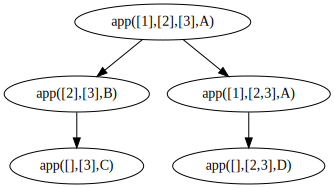

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">R = [1,2,3]</pre>

In [55]:
jupyter:print_sld_tree(app([1], [2], [3], R)).

### Creating Transition Graphs <a id='transition_graphs'></a> 

There is another predicate with which a graph can be created: `jupyter:print_transition_graph(PredSpec, FromIndex, ToIndex, LabelIndex)`.<br>
It computes all solutions of the predicate with specification `PredSpec` and uses them to create the graph.<br>

`PredSpec` needs to be of the form `PredName/PredArity` or `Module:PredName/PredArity`.<br>
`FromIndex` and `ToIndex` point to predicate arguments used as nodes.<br>
`LabelIndex` points to the argument providing a label for an edge.<br>
If `LabelIndex`=0, no label is shown.<br>

In order to be recognized as a special predicate, it needs to be the only goal of a query.

In [56]:
edge(a, 4, b).
edge(a, 3, c).
edge(b, 9, c).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Asserting clauses for user:edge/3
</pre>

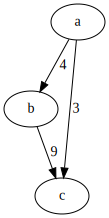

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

In [57]:
jupyter:print_transition_graph(edge/3, 1, 3, 2).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Asserting clauses for user:two_way_edge/3
</pre>

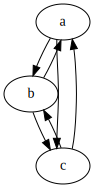

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

In [58]:
two_way_edge(N1, L, N2) :- edge(N1, L, N2).
two_way_edge(N1, L, N2) :- edge(N2, L, N1).

?- jupyter:print_transition_graph(two_way_edge/3, 1, 3, 0).

### Changing the Prolog Implementation <a id='changing_prolog_implementation'></a> 

If implementation specific data is configured for more than one Prolog implementation (see [Kernel Configuration](#kernel_configuration)), the active Prolog implementation used for code execution can be changed with `jupyter:set_prolog_impl(+PrologImplementationID)`.<br>
It needs to be noted that the implementation is changed after all code of the cell has been executed.<br>
Therefore, any code following a `jupyter:set_prolog_impl/1` query in the same cell is still executed with the previous active implementation.

The server for the previously used implementation is kept running so that when changing back, the state has not changed.<br>
For example, the previous variable bindings still exist.<br>
When the Jupyter kernel is interrupted, all running Prolog servers are killed and need to be restarted the next time code is executed.<br>
In order to restart a single Prolog process, `jupyter:halt/0` can be used (see [Reset the Prolog State](#reset_state)).

In [59]:
halt.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">% Successfully halted</pre>

In [60]:
X = [1,2,3].

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;color:red">% The Prolog server was restarted</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">X = [1,2,3]</pre>

In [ ]:
append([1], [2], [1,2,3]).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;color:red; font-weight:bold;">false</pre>

In [62]:
?- jupyter:print_variable_bindings.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">$X =        [1,2,3]</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

After changing to SICStus Prolog, the success and failure output is different and there are no previous variable bindings.

In [63]:
jupyter:set_prolog_impl(sicstus).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>

In [ ]:
append([1], [2], [1,2,3]).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;color:red; font-weight:bold;">no</pre>

In [65]:
jupyter:print_variable_bindings.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">No previous variable bindings</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">yes</pre>

Changing back to SWI-Prolog, the previous state has not been changed.<br>
For example, the variable bindings still exist.

In [66]:
jupyter:set_prolog_impl(swi).

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">yes</pre>

In [67]:
jupyter:print_variable_bindings.

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;">$X =        [1,2,3]</pre>

<pre style="font-family: Menlo, Consolas, 'DejaVu Sans Mono', monospace; font-size: 13px; line-height: 1.3077;font-weight:bold;">true</pre>